# Changing Noises

This notebook investigates how the reference scenario evolves if we change:
- The intensities of feature and distinct noises.
- The shape of the distribution used to draw candidate utilities, feature noises, and distinct noises.

In [1]:
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import tikzplotlib
from multiprocess.pool import Pool

In [2]:
import embedded_voting as ev # Our own module

Direct load of some useful variables and functions.

In [3]:
from embedded_voting.experiments.aggregation import make_generator, make_aggs, f_max, f_renorm
from embedded_voting.experiments.aggregation import handles, colors, evaluate, default_order

In [4]:
n_tries = 10000 # Number of simulations
n_training = 1000 # Number of training samples for trained rules
n_c = 20

## Changing Noise Intensities

### Computation

In [5]:
res = np.zeros( (9, 3, 3) )
with Pool() as p:
    for j, distinct_noise in enumerate([.1, 1, 10]):
        for k, group_noise in enumerate([.1, 1, 10]):
            generator = make_generator(feat_noise=group_noise, dist_noise=distinct_noise)
            training = generator(n_training)
            testing = generator(n_tries*n_c).reshape(generator.n_voters, n_tries, n_c)
            truth = generator.ground_truth_.reshape(n_tries, n_c)

            list_agg = make_aggs(distinct_noise=distinct_noise, group_noise=group_noise)
            res[:, j, k] = evaluate(list_agg=list_agg, truth=truth, 
                                    testing=testing, training=training, pool=p)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 656.05it/s]


We save the results.

In [6]:
with open('noises_intensity.pkl', 'wb') as f:
    pickle.dump(res, f)

### Display

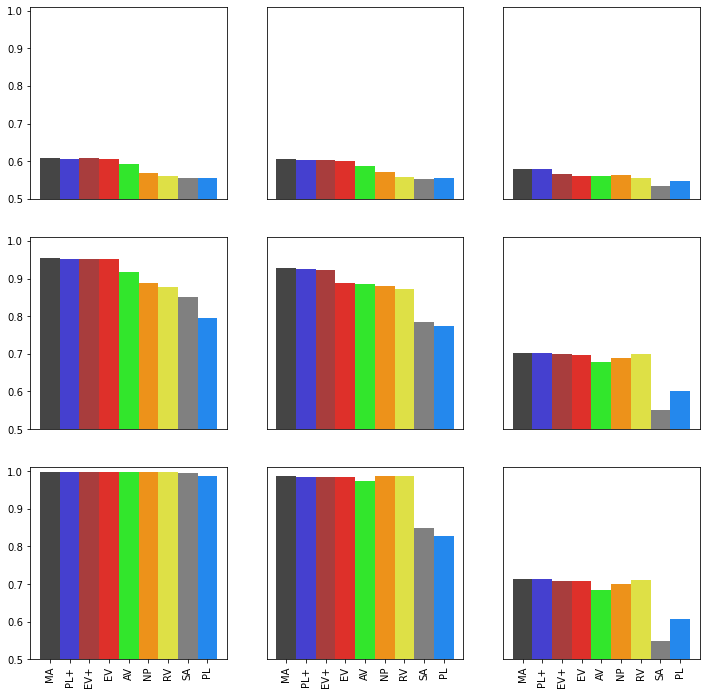

In [7]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

n_agg = len(list_agg)
for j in range(3):
    for k in range(3):
        ax[j,k].bar(np.arange(n_agg), res[:, k, 2-j], color=[colors[agg.name] for agg in list_agg], width=1)
        ax[j,k].set_ylim(0.5,1.01)
        ax[j,k].set_xlim(-1, n_agg)
        if k != 0:
            ax[j,k].get_yaxis().set_visible(False)
            ax[j,k].set_yticks([])
        if j == 2:            
            ax[j,k].set_xticks(np.arange(n_agg))
            ax[j,k].set_xticklabels([handles[agg.name] for agg in list_agg], rotation=90)
        else:
            ax[j,k].get_xaxis().set_visible(False)
            ax[j,k].set_xticks([])
        
plt.ylabel("Average relative utility")
tikzplotlib.save("noises_intensity.tex")

# Save figure:
plt.savefig("noises_intensity.png")

# Show the graph
plt.show()

## Changing Noise Distributions

Finally, we try different noise functions to deviate from a normal distribution. First we try wider and thiner distributions, using _gennorm_, and then we try skewed distributions, using _skewnorm_. In all cases, mean and standard deviations stay the same, only the higher moments are altered.

This analysis is not shown in the paper due to space constraints.

### Considered Distributions

For illustration, we display the density of each considered distribution, normalized with 0 mean and unit standard deviation.

In [8]:
from scipy.stats import gennorm, skewnorm, norm
def normalize(rv, a, x):
    _, var = rv.stats(a, moments='mv')
    scale = 1/np.sqrt(var)
    mean, _ = rv.stats(a, scale=scale, moments='mv')
    return rv.pdf(x, a, loc=-mean, scale=scale)    

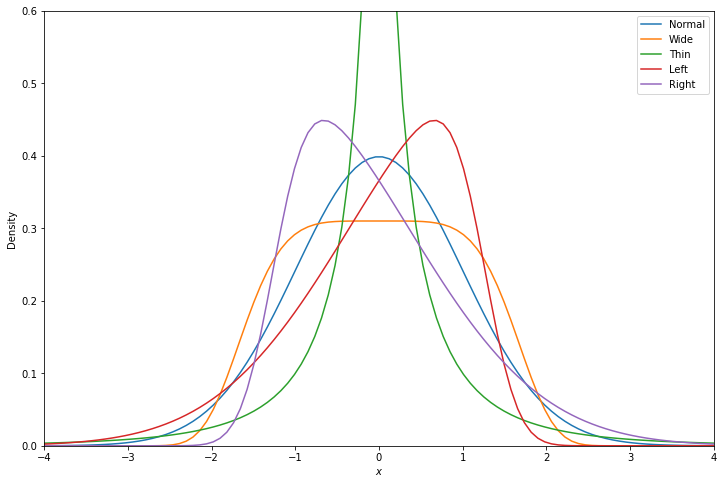

In [9]:
plt.figure(figsize=(12, 8))
x = np.linspace(-4, 4, 100)
plt.plot(x, norm.pdf(x), label='Normal')
plt.plot(x, normalize(gennorm, 5, x), label='Wide')
plt.plot(x, normalize(gennorm, .5, x), label='Thin')
plt.plot(x, normalize(skewnorm, -5, x), label='Left')
plt.plot(x, normalize(skewnorm, 5, x), label='Right')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('Density')
plt.xlim([-4, 4])
plt.ylim([0, .6])
plt.show()

### Computation

In [10]:
def create_gennorm(beta=1):
    std = gennorm.rvs(beta, scale=1, size=100000).std()
    scale = 1/std
    def f1(size):
        return gennorm.rvs(beta, scale=scale, size=size)
    return f1


def create_skewnorm(beta=1):
    std = skewnorm.rvs(beta, scale=1, size=100000).std()
    scale = 1/std
    def f1(size):
        return skewnorm.rvs(beta, scale=scale, size=size)
    return f1

In [11]:
list_noise = [None, create_gennorm(5), create_gennorm(0.5), create_skewnorm(-5), create_skewnorm(5)]
dist_names = ["N", "W", "T",  "L", "R"]

In [12]:
res = np.zeros((9, 5))
# No need to recompute base case
with open('base_case_results.pkl', 'rb') as f:
    res[:, 0] = pickle.load(f)[:-1]
list_agg = make_aggs()

In [13]:
with Pool() as p:
    for i in range(1, 5):    
        generator = make_generator(truth=ev.TruthGeneratorGeneral(list_noise[i]),
                                  feat_f=list_noise[i],
                                  dist_f=list_noise[i])
        training = generator(n_training)
        testing = generator(n_tries*n_c).reshape(generator.n_voters, n_tries, n_c)
        truth = generator.ground_truth_.reshape(n_tries, n_c)

        res[:, i] = evaluate(list_agg=list_agg, truth=truth, 
                             testing=testing, training=training, pool=p)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 756.62it/s]


We save the results.

In [14]:
with open('noises_function.pkl', 'wb') as f:
    pickle.dump(res, f)

### Display

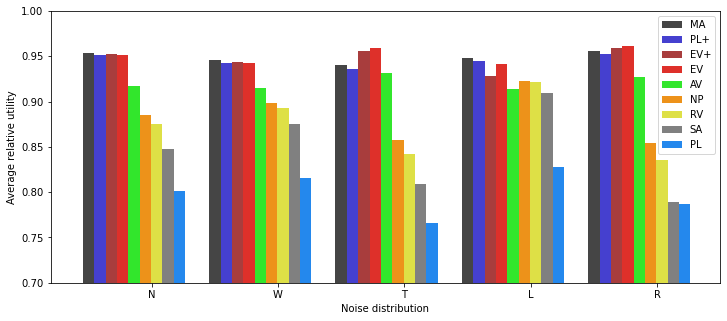

In [15]:
plt.figure(figsize=(12,5))

for i, agg in enumerate(list_agg):
    plt.bar([j-0.5+0.09*i for j in range(5)], res[i,:],  color=colors[agg.name], 
            label=handles[agg.name], width=0.09)

plt.legend()
plt.xticks([i*1 for i in range(5)], dist_names)
plt.xlabel("Noise distribution")
plt.ylabel("Average relative utility")
plt.ylim(0.7,1)
plt.xlim(-0.8,4.5)

tikzplotlib.save("noise_function.tex")
# save figure:
plt.savefig("noise_function.png")
plt.show()

We note that MA is no longer a maximum-likelihood estimator as it assumes an incorrect underlying model. The same holds for its approximations PL and PL+. And indeed MA is no longer a *de facto* upper bound of performance: it is outperformed in case R, and even more in case T, by EV/EV+.